# GITC22 Driller Demo Environment

## Copyright

*Copyright Geoscience DS&ML Special Interest Group, 2022.*
*License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)*
*Author(s): [Altay Sansal](https://github.com/tasansal), Eduardo Alvarez*

## Prerequisites

This notebook assumes familiarity with Reinforcement Learning concepts (agents, spaces, actions, ...) and knowledge of [OpenAI's Gym](https://www.gymlibrary.ml/) APIs and environments.

To better understand what we are trying to do, please refer to our hello world example notebook [here](https://github.com/GeoML-SIG/wildcatter/blob/main/examples/01_rl_hello_world_cartpole.ipynb).

# Start Workflow

Let's some libraries we are going to use for getting and plotting trajectory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Gym Agent and Environment

We created a simple Environment based on OpenAI's Gym interface. This is contained within Wildcatter's `environment` module.

### Things to Know
1. The only observation of the model state is the borehole trajectory, production or reservoir is not considered in reward.
2. Surface hole location is randomly selected at each environment reset.
3. Collision logic is implemented in three ways:
    3.1. Game over if agent hits East or West boundaries.
    3.2. Game over if agent hits North (surface) or South boundaries.
    3.3. Game over if borehole collides with itself.
4. Realistically all that can be optimized now is drilling direction based on available drill pipe, proximity to reservoir, etc.

The action space consists of four discrete actions:

Action Space:

| Num | Action         |
|:---:|----------------|
|  0  | Move bit down  |
|  1  | Move bit left  |
|  2  | Move bit right |
|  3  | Move bit up    |

The Observation Space:

It is a Box observation space with 40 rows and 80 columns.
Data type is `bool` and it will be True where the well trajectory is.
The RL algorithm will see the full trajectory as the state.

`bit_location = [row, col] = [depth, surface_loc]`

`trajectory = [[row1, col1], [row2, col2], ..., [rowN, colN]]`

All reward models are created using tiled, here is the download link [here](https://www.mapeditor.org/).

# Create Driller Environment Module

Below is the driller environment module. It was in a separate file but the module wouldn't run that way... so it's been cut and pasted here below.

In [72]:
"""Driller environment module."""


from __future__ import annotations

import random
from typing import Any

import numpy as np
from gym import Env
from gym.spaces import Box
from gym.spaces import Discrete
from numpy.typing import NDArray


class SimpleDriller(Env):  # type: ignore
    """Simple driller environment."""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        self.model = np.loadtxt(
            env_config["model_path"],
            delimiter=env_config["delim"],
        )

        self.nrow, self.ncol = self.model.shape
        self.available_pipe = env_config["available_pipe"]

        self.production = 0
        self.pipe_used = 0
        self.wells_drilled = 0 # adding in code here to drill multiple wells. We first set it to zero.
        self.max_wells = 5 # this line will set the maximum number of wells the agent can drill
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []

        self.action_space = Discrete(4)

        self.observation_space = Box(
            low=self.model.min(), high=self.model.max(), shape=(self.nrow, self.ncol), dtype=np.float32 #creates an array of False values
        )
        self.reset()

    def step(  # noqa: C901
        self, action: int
    ) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        done = False
        actions = {
            0: [1, 0],  # down
            1: [0, -1],  # left
            2: [0, 1],  # right
            3: [-1, 0],  # up
        }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            reward = -100

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            reward = -100

        else:
            reward = self.model[newrow, newcol] + self.pipe_used / 10
            self.update_state()
            
            
        if self.pipe_used == self.available_pipe:
            self.bit_location = [1, random.randint(0, self.ncol - 1)]   #if we run out of pipe, put the bit back at a random start location
            self.pipe_used = 0                                          # reset the amount of pipe used to zero
            self.wells_drilled += 1                                   # increase the number of wells drilled
            
        if self.wells_drilled == self.max_wells: # here we tell the agent to stop if it reaches the max number of wells
            done = True
            reward = reward + 1 # because the agent already recieved a reward in the first set of if statement, we will add a small bonus reward if it makes it to the end.

        if self.bit_location in self.trajectory[:-1]:
            done = True
            reward = -100

        info: dict[str, Any] = {}

        return self.state, reward, done, info

    def update_state(self) -> None:
        """Update state method."""
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = -1

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")

    def reset(self):
        """Reset the status of the environment."""
        self.surface_hole_location = [1, random.randint(0, self.ncol - 1)]  # noqa: S311
        self.state = self.model
        self.bit_location = self.surface_hole_location
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        return self.state


## PPO Agent Training

Here we will import Proximal Policy Optimization (PPO) algorithm from Stable Baselines3 and train it with minimal parameters.

We allow it to train for 50,000 time samples.

For more information about PPO, please refer to our hello world example notebook [here](https://github.com/GeoML-SIG/wildcatter/blob/main/examples/01_rl_hello_world_cartpole.ipynb).

In [81]:
#Set up the path for the environment csv file, the amount of pipe and the delimiter for the csv
env_config = dict(model_path=r"data/2d_stacked_edit.csv", available_pipe=30, delim=",")

#create our environment object
env = SimpleDriller(env_config)

#import our model algorithm
from stable_baselines3 import PPO

#train the model
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=500_000, log_interval=50)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 1        |
|    ep_rew_mean          | 0.1      |
| time/                   |          |
|    fps                  | 793      |
|    iterations           | 50       |
|    time_elapsed         | 129      |
|    total_timesteps      | 102400   |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0284  |
|    explained_variance   | 1        |
|    learning_rate        | 0.0003   |
|    loss                 | 2.13e-14 |
|    n_updates            | 490      |
|    policy_gradient_loss | 0        |
|    value_loss           | 3.81e-14 |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep

Once learning is complete, we can use the model to generate a new trajectory to maximize reward.

We will be using the same code snippet from above, but replacing the action generation with the `model.predict()` method, instead
of randomly sampling from the action space.

Beginning Drill Campaign: 1


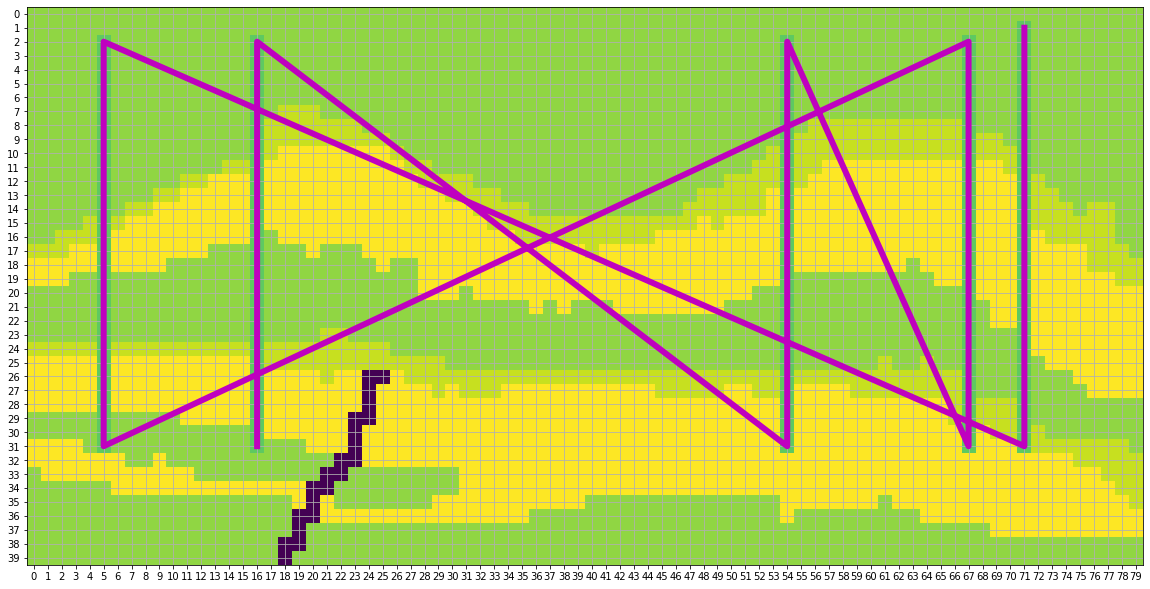

In [82]:
env = SimpleDriller(env_config)

episodes = 1
for episode in range(1, episodes + 1):
    print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
    score = 0

    while not done:
        action, _states = model.predict(state)
        state, reward, done, info = env.step(action)
        score += reward
        

# This comes in as [[row1, col1], ..., [rowN, colN]]
# Once we unpack it its z, then x.
traj_z, traj_x = np.asarray(env.trajectory).T

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)
plt.plot(traj_x, traj_z, "-", c="m", linewidth=6)
plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.xlim([-0.5, 79.5])
plt.ylim([39.5, -0.5])
plt.grid()

## Visualize State

As we mentioned before, the state is binary (boolean) well trajectory. If we wanted to plot it, we get the `state` attribute and use `imshow`.

Remember, this is what the RL algorithm sees! There is a lot of room for improving the observation of the system to optimize the drilling parameters.

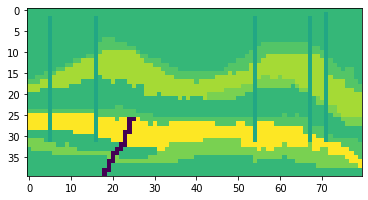

In [83]:
plt.imshow(env.state)

# Model in Additional Environment
Here we will implement the model in a simple 2D anticline environment

## PPO Training in New Environment

In [84]:
#Set up the path for the environment csv file, the amount of pipe and the delimiter for the csv
env_config = dict(model_path=r"data/anticline.csv", available_pipe=30, delim=",")

#create our environment object
env = SimpleDriller(env_config)

#import our model algorithm
from stable_baselines3 import PPO

#train the model
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50_000, log_interval=50)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Beginning Drill Campaign: 1


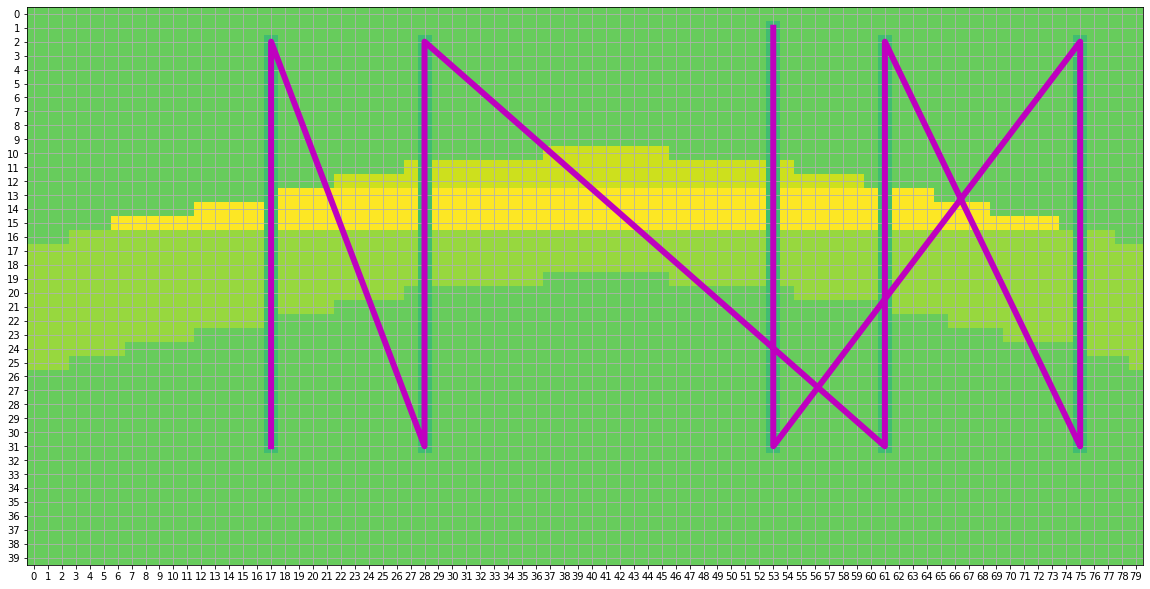

In [85]:
env = SimpleDriller(env_config)

episodes = 1
for episode in range(1, episodes + 1):
    print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
    score = 0

    while not done:
        action, _states = model.predict(state)
        state, reward, done, info = env.step(action)
        score += reward
        

# This comes in as [[row1, col1], ..., [rowN, colN]]
# Once we unpack it its z, then x.
traj_z, traj_x = np.asarray(env.trajectory).T

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=3)
plt.plot(traj_x, traj_z, "-", c="m", linewidth=6)
plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.xlim([-0.5, 79.5])
plt.ylim([39.5, -0.5])
plt.grid()

## Visualize State in New Environment

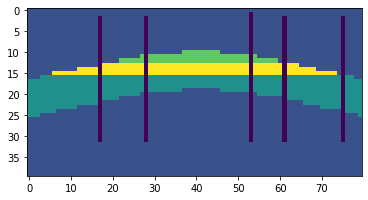

In [86]:
plt.imshow(env.state)

# Conclusion

We trained a driller to maximize reward based on traversing the "earth model".

The current approach has many known limitations, such as:
1. There is no proximity to pay in observation (state), hence it only learns to go down and sometimes diagonal to maximize reward. With the given observations, this is acceptable!
2. The reward system is not very realistic, 1-5 values indicate ok to best "reservoirs".
3. Reservoir covers the whole interval, there are no specific "targets".
4. No geo-mechanics
5. No real cost
6. And more missing dynamics!

We left the low-hanging fruit for the GITC22 participants to explore and implement. Have fun!